<a href="https://colab.research.google.com/github/Jackwangnao/Food-Classification---CNN/blob/master/less_conv_CNN_food_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Jun 23 17:24:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip show torch

Name: torch
Version: 1.5.1+cu101
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, future
Required-by: torchvision, torchtext, fastai


# 导入相关库

In [ ]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import metrics

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 读取图片数据

由于是公开数据集，可通过以下方法直接下载，速度较快省去了上传数据集到谷歌硬盘的操作，更加简便

In [ ]:
!gdown --id '19CzXudqN58R3D-1G8KeFWk8UDQwlb8is' --output food-11.zip # 下载数据集
!unzip food-11.zip # 解压缩

Streaming output truncated to the last 5000 lines.
  inflating: food-11/training/4_165.jpg  
  inflating: food-11/training/5_376.jpg  
  inflating: food-11/training/2_691.jpg  
  inflating: food-11/training/0_541.jpg  
  inflating: food-11/training/3_482.jpg  
  inflating: food-11/training/0_227.jpg  
  inflating: food-11/training/5_410.jpg  
  inflating: food-11/training/4_603.jpg  
  inflating: food-11/training/8_341.jpg  
  inflating: food-11/training/5_1154.jpg  
  inflating: food-11/training/9_37.jpg  
  inflating: food-11/training/9_152.jpg  
  inflating: food-11/training/5_438.jpg  
  inflating: food-11/training/9_1287.jpg  
  inflating: food-11/training/8_369.jpg  
  inflating: food-11/training/2_1455.jpg  
  inflating: food-11/training/10_247.jpg  
  inflating: food-11/training/7_32.jpg  
  inflating: food-11/training/10_521.jpg  
  inflating: food-11/training/2_1333.jpg  
  inflating: food-11/training/2_861.jpg  
  inflating: food-11/training/0_569.jpg  
  inflating: food-11/

## 定义读取图片的函数 `readfile()`

用`OpenCV（cv2）`读取图片并存放在`numpy.ndarray`中

In [ ]:
def readfile(path, label):
    # label 是一个布尔值，代表需不需要返回 y 值
    image_dir = sorted(os.listdir(path))
    # x存储图片，每张彩色图片都是128(高)*128(宽)*3(彩色三通道)
    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8)
    # y存储标签，每个y大小为1
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        img = cv2.imread(os.path.join(path, file))
        # 利用cv2.resize()函数将不同大小的图片统一为128(高)*128(宽)
        x[i, :, :] = cv2.resize(img,(128, 128))
        if label:
          y[i] = int(file.split("_")[0])
    if label:
      return x, y
    else:
      return x

## 用函数`readfile()` 读取  `training set`、`validation set`、`testing set`

In [ ]:
#分别将 training set、validation set、testing set 用函数 readfile() 读进来
workspace_dir = './food-11'
print("Reading data")
train_x, train_y = readfile(os.path.join(workspace_dir, "training"), True)
print("Size of training data = {}".format(len(train_x)))
val_x, val_y = readfile(os.path.join(workspace_dir, "validation"), True)
print("Size of validation data = {}".format(len(val_x)))
test_x = readfile(os.path.join(workspace_dir, "testing"), False)
print("Size of Testing data = {}".format(len(test_x)))

Reading data
Size of training data = 9866
Size of validation data = 3430
Size of Testing data = 3347


# 定义Dataset

In [ ]:
#training 时，通过随机旋转、水平翻转图片来进行数据增强（data augmentation）
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), #随机翻转图片
    transforms.RandomRotation(15), #随机旋转图片
    transforms.ToTensor(), #将图片变成 Tensor，并且把数值normalize到[0,1]
])
#testing 时，不需要进行数据增强（data augmentation）
test_transform = transforms.Compose([
    transforms.ToPILImage(),                                    
    transforms.ToTensor(),
])
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label 需要是 LongTensor 型
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [ ]:
batch_size = 128
train_set = ImgDataset(train_x, train_y, train_transform)
val_set = ImgDataset(val_x, val_y, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# 定义模型

* 卷积神经网络 + 全连接的前向传播神经网络
* 卷积神经网络的每级卷积层由卷积层`conv` + 批标准化`batchnorm` + 激活函数`ReLU` + 最大池化`MaxPool`构成。

本模型与最初提出模型（见`CNN_food_classification.ipynb`）相比，减少了卷积层个数

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        #torch.nn.MaxPool2d(kernel_size, stride, padding)
        #input 维度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # 输出[64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # 输出[64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # 输出[128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # 输出[128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # 输出[256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # 输出[256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # 输出[512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # 输出[512, 8, 8]
            
        )
        # 全连接的前向传播神经网络
        self.fc = nn.Sequential(
            nn.Linear(512*8*8, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)   # 最后是11个分类
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)  # 摊平成1维
        return self.fc(out)

# 训练 

## 仅使用训练集`train test`

In [ ]:
model = Classifier().cuda() # 用cuda加速
loss = nn.CrossEntropyLoss() # 因为是分类任务，所以使用交叉熵损失 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 使用Adam优化器
num_epoch = 30 # 迭代次数
train_loss_record = [] # 记录每代训练集的loss
val_loss_record = [] # 记录每代验证集的loss
train_acc_record = [] # 记录每代训练集的accuracy
val_acc_record = [] # 记录每代验证集的accuracy

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    model.train() # 确保 model 是在 训练 model (开启 Dropout 等...)
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() # 用 optimizer 将模型参数的梯度 gradient 归零
        train_pred = model(data[0].cuda()) # 利用 model 得到预测的概率分布，这边实际上是调用模型的 forward 函数
        batch_loss = loss(train_pred, data[1].cuda()) # 计算 loss （注意 prediction 跟 label 必须同时在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每个参数的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新参数

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
    
    #验证集val
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred, data[1].cuda())

            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()

        #将结果 print 出來
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))
        
        train_loss_record.append(train_loss/train_set.__len__())
        val_loss_record.append(val_loss/val_set.__len__())
        train_acc_record.append(train_acc/train_set.__len__())
        val_acc_record.append( val_acc/val_set.__len__())

[001/030] 31.04 sec(s) Train Acc: 0.210521 Loss: 0.028579 | Val Acc: 0.209329 loss: 0.016666
[002/030] 30.96 sec(s) Train Acc: 0.298399 Loss: 0.015490 | Val Acc: 0.316618 loss: 0.014709
[003/030] 31.00 sec(s) Train Acc: 0.378370 Loss: 0.013909 | Val Acc: 0.367055 loss: 0.014493
[004/030] 31.05 sec(s) Train Acc: 0.426009 Loss: 0.013030 | Val Acc: 0.364723 loss: 0.014922
[005/030] 31.12 sec(s) Train Acc: 0.454389 Loss: 0.012397 | Val Acc: 0.439067 loss: 0.012807
[006/030] 31.27 sec(s) Train Acc: 0.487533 Loss: 0.011430 | Val Acc: 0.396210 loss: 0.013853
[007/030] 31.35 sec(s) Train Acc: 0.498986 Loss: 0.011271 | Val Acc: 0.319825 loss: 0.016642
[008/030] 31.44 sec(s) Train Acc: 0.533550 Loss: 0.010617 | Val Acc: 0.402915 loss: 0.014522
[009/030] 31.46 sec(s) Train Acc: 0.547841 Loss: 0.010287 | Val Acc: 0.438776 loss: 0.013819
[010/030] 31.44 sec(s) Train Acc: 0.580073 Loss: 0.009510 | Val Acc: 0.488921 loss: 0.012171
[011/030] 31.51 sec(s) Train Acc: 0.591121 Loss: 0.009318 | Val Acc: 0

Text(0.5, 1.0, 'Loss curve')

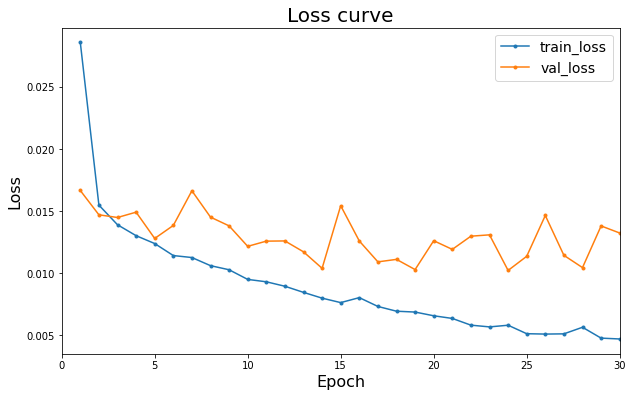

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
ax.plot([epoch+1 for epoch in range(num_epoch)], train_loss_record, '.-', label='train_loss')
ax.plot([epoch+1 for epoch in range(num_epoch)], val_loss_record, '.-', label='val_loss')
ax.set_xlim([0,num_epoch+1])
ax.set_xlabel('Epoch',fontsize=16)
ax.set_ylabel('Loss',fontsize=16)
ax.legend(fontsize=14)
ax.set_title('Loss curve',fontsize=20)

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
ax.plot([epoch+1 for epoch in range(num_epoch)], train_acc_record, '.-', label='train_accuracy')
ax.plot([epoch+1 for epoch in range(num_epoch)], val_acc_record, '.-', label='val_accuracy')
ax.set_xlim([0,num_epoch+1])
ax.set_xlabel('Epoch',fontsize=16)
ax.set_ylabel('Accuracy',fontsize=16)
ax.legend(fontsize=14)
ax.set_title('Accuracy curve',fontsize=20)

## 使用训练集 `training set` 和验证集 `validation set`一起训练
仅使用训练集进行训练模型效果还可以，说明定义的模型可行，这里将训练集和验证集一起用来训练模型，数据量更大，应该模型表现会更好

In [ ]:
train_val_x = np.concatenate((train_x, val_x), axis=0) # 将train_x和val_x拼接起来
train_val_y = np.concatenate((train_y, val_y), axis=0) # 将train_y和val_y拼接起来
train_val_set = ImgDataset(train_val_x, train_val_y, train_transform)
train_val_loader = DataLoader(train_val_set, batch_size=batch_size, shuffle=True)

In [ ]:
model_best = Classifier().cuda() # cuda加速
loss = nn.CrossEntropyLoss() # 因为是分类任务，所以使用交叉熵损失 
optimizer = torch.optim.Adam(model_best.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 30
loss_record = [] # 记录每代的loss
acc_record = []  # 记录每代的accuracy

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0

    model_best.train()
    for i, data in enumerate(train_val_loader):
        optimizer.zero_grad()
        train_pred = model_best(data[0].cuda())
        batch_loss = loss(train_pred, data[1].cuda())
        batch_loss.backward()
        optimizer.step()

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

    # 将结果 print 出来
    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f' % \
      (epoch + 1, num_epoch, time.time()-epoch_start_time, \
      train_acc/train_val_set.__len__(), train_loss/train_val_set.__len__()))
    
    loss_record.append(train_loss/train_val_set.__len__())
    acc_record.append(train_acc/train_val_set.__len__())

[001/030] 37.22 sec(s) Train Acc: 0.235108 Loss: 0.024330
[002/030] 37.43 sec(s) Train Acc: 0.351835 Loss: 0.014360
[003/030] 37.59 sec(s) Train Acc: 0.415539 Loss: 0.013065
[004/030] 37.73 sec(s) Train Acc: 0.466757 Loss: 0.011989
[005/030] 37.72 sec(s) Train Acc: 0.502106 Loss: 0.011234
[006/030] 37.70 sec(s) Train Acc: 0.539937 Loss: 0.010396
[007/030] 37.77 sec(s) Train Acc: 0.568893 Loss: 0.009703
[008/030] 37.73 sec(s) Train Acc: 0.597323 Loss: 0.009124
[009/030] 37.76 sec(s) Train Acc: 0.618983 Loss: 0.008697
[010/030] 37.73 sec(s) Train Acc: 0.639816 Loss: 0.008127
[011/030] 37.72 sec(s) Train Acc: 0.655611 Loss: 0.007733
[012/030] 37.64 sec(s) Train Acc: 0.669525 Loss: 0.007344
[013/030] 37.79 sec(s) Train Acc: 0.686071 Loss: 0.007082
[014/030] 37.72 sec(s) Train Acc: 0.705400 Loss: 0.006588
[015/030] 37.85 sec(s) Train Acc: 0.721946 Loss: 0.006243
[016/030] 37.74 sec(s) Train Acc: 0.733604 Loss: 0.006012
[017/030] 37.80 sec(s) Train Acc: 0.736462 Loss: 0.005800
[018/030] 37.8

Text(0.5, 1.0, 'Loss curve')

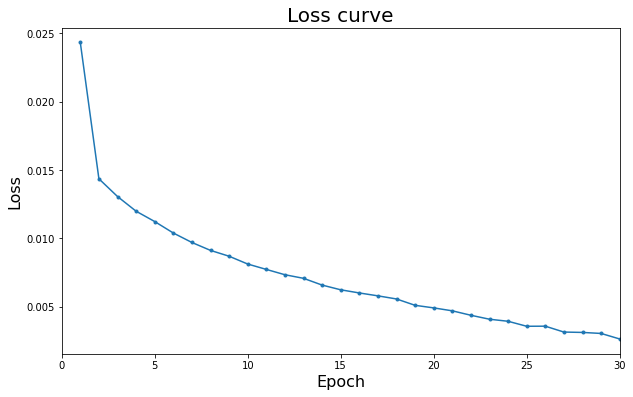

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
ax.plot([epoch+1 for epoch in range(num_epoch)], loss_record, '.-')
ax.set_xlim([0,num_epoch])
ax.set_xlabel('Epoch',fontsize=16)
ax.set_ylabel('Loss',fontsize=16)
ax.set_title('Loss curve',fontsize=20)

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
ax.plot([epoch+1 for epoch in range(num_epoch)], acc_record, '.-')
ax.set_xlim([0,num_epoch+1])
ax.set_xlabel('Epoch',fontsize=16)
ax.set_ylabel('Accuracy',fontsize=16)
ax.set_title('Accuracy curve',fontsize=20)

# 测试

用刚才训练好的模型，在`test set`上进行测试。

In [ ]:
test_set = ImgDataset(test_x, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
model_best.eval()
test_prediction = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        test_pred = model_best(data.cuda())
        # 预测值中概率最大的下标即为模型预测的食物标签
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        for y in test_label:
            test_prediction.append(y)

In [ ]:
#将预测结果写入 csv 
from google.colab import drive
drive.mount('drive')
test_predict_result = pd.DataFrame({'Id':np.arange(len(test_x)).tolist(), 'Category': test_prediction})
test_predict_result.to_csv('less_conv_CNN_food_classification.csv', index=False)
!cp less_conv_CNN_food_classification.csv drive/My\ Drive/Colab\ Output\ File/

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


# 误差矩阵

In [ ]:
# 得到训练集和验证集的预测值
train_val_x_set = ImgDataset(train_val_x, transform=test_transform)
train_val_x_loader = DataLoader(train_val_x_set, batch_size=batch_size, shuffle=False)

model_best.eval()
prediction = []
with torch.no_grad():
    for i, data in enumerate(train_val_x_loader):
        train_val_pred = model_best(data.cuda())
        # 预测值中概率最大的下标即为模型预测的食物标签
        train_val_label = np.argmax(train_val_pred.cpu().data.numpy(), axis=1)
        for y in train_val_label:
            prediction.append(y)

In [ ]:
# 计算误差矩阵
matrix = metrics.confusion_matrix(train_val_y,prediction)
matrix_prop = matrix / matrix.sum(axis=1).reshape(11, -1)

Text(0.5, 1.0, 'Confusion matrix')

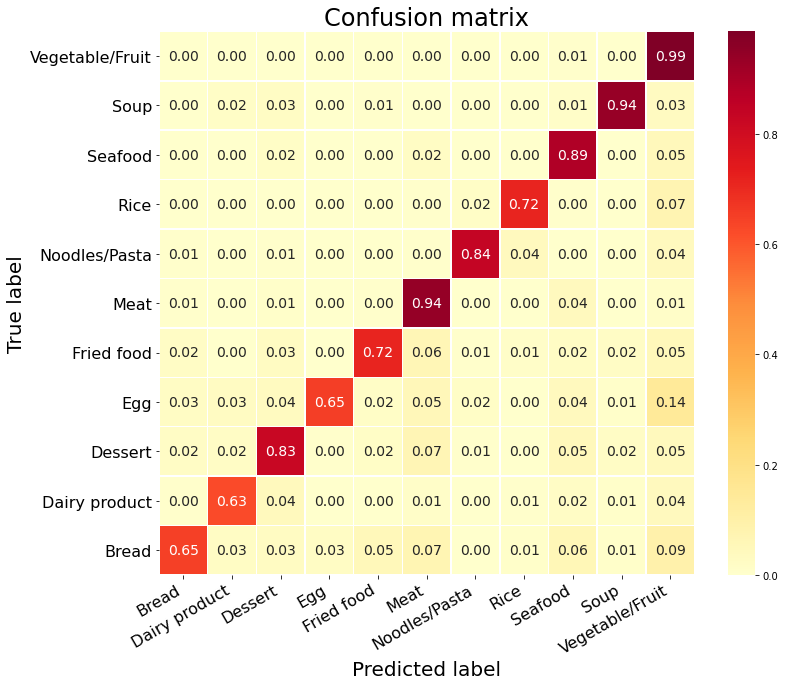

In [ ]:
# 绘制误差矩阵图
f, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(matrix_prop, annot=True, annot_kws={'size': 14}, fmt='.2f', cmap='YlOrRd',
            linewidths=.5, ax=ax)

ax.set_ylim([0, 11])
ax.set_xticks(np.arange(11) + 0.5)
ax.set_xticklabels(['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 
                    'Meat', 'Noodles/Pasta', 'Rice', 'Seafood', 'Soup', 
                    'Vegetable/Fruit'], rotation=30, ha='right')
ax.set_yticks(np.arange(11) + 0.5)
ax.set_yticklabels(['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 
                    'Meat', 'Noodles/Pasta', 'Rice', 'Seafood', 'Soup', 
                    'Vegetable/Fruit'], rotation=0)
plt.tick_params(labelsize=16)
plt.xlabel('Predicted label',fontsize=20)
plt.ylabel('True label',fontsize=20)
ax.set_title('Confusion matrix', {'size': 24})